In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [5]:
df = pd.read_csv('test.csv')
df

,Time(hrs),40,50,60,70,80
0,0.00,0.00,0.00,0.00,0.00,0.00
1,0.25,0.03,0.04,0.05,0.09,0.14
2,0.50,0.04,0.06,0.09,0.14,0.23
3,1.00,0.05,0.10,0.15,0.20,0.36
4,2.00,0.08,0.15,0.25,0.35,0.50
5,4.00,0.15,0.28,0.44,0.62,0.80


In [25]:
temps = [temp for temp in df.columns][1:]
temps
for i,temp in enumerate(temps):
    print(df[df.columns[i]])

0    0.00
1    0.25
2    0.50
3    1.00
4    2.00
5    4.00
Name: Time(hrs), dtype: float64
0    0.00
1    0.03
2    0.04
3    0.05
4    0.08
5    0.15
Name: 40, dtype: float64
0    0.00
1    0.04
2    0.06
3    0.10
4    0.15
5    0.28
Name: 50, dtype: float64
0    0.00
1    0.05
2    0.09
3    0.15
4    0.25
5    0.44
Name: 60, dtype: float64
0    0.00
1    0.09
2    0.14
3    0.20
4    0.35
5    0.62
Name: 70, dtype: float64


In [13]:
def plot_recoveries (df):
    t = np.array(df[df.columns[0]])
    temps = [temp for temp in df.columns][1:]
    plt.figure(figsize = (10,8))
    #plt.plot(t,[df[df.columns[i+1]] for i in range(len(temps))])
    for i,temp in enumerate(temps):
        plt.plot(t,df[df.columns[i+1]] , label = str(temp))
    plt.xlabel(df.columns[0])
    plt.ylabel('Extraction')
    plt.legend()
    plt.show()

def surface_chem(df):
    arrs = [np.array(df[col]) for col in df.columns[1:]]
    LH = [(1 - (1-arrs[i])**(1/3)) for i in range(len(arrs))]
    model_linear = "1 - (1-X)**(1/3)"
    return(LH,model_linear)

def diffusion(df):
    arrs = [np.array(df[col]) for col in df.columns[1:]]
    LH = [(1 - (2/3)*arrs[i]-(1-arrs[i])**(2/3)) for i in range(len(arrs))]
    model_linear = "1 - (2/3)*X - (1-X)**(2/3)"
    model_name = 'Diffusion'
    return(LH, model_linear)

def plot_linear_model(df,LH,linear_model,model_name):
    t = np.array(df[df.columns[0]])
    temps = [temp for temp in df.columns][1:]
    plt.figure(figsize = (10,8))
    for i,entry in enumerate(LH):
        res = stats.linregress(t,entry)
        plt.plot(t,res.intercept + res.slope*t)
        plt.scatter(t,entry)
        plt.ylabel(linear_model)
        plt.xlabel('t')
        plt.title(model_name)
        print(temps[i],res.slope*1000,res.rvalue)
        #plt.legend(temps) still need to fix this
        

def plot_linear_kinetic_selected_models (selected_models):
    for model in selected_models:
        LH = model(df)[0]
        model_linear = model(df)[1]
        model_name = model.__name__
        plot_linear_model(df,LH,model_linear,model_name)
        
def evaluate(df,LH):
    t = np.array(df[df.columns[0]])
    temps = [temp for temp in df.columns][1:]
    res_temps = []
    res_slopes = []
    res_rvalues= []
    for i,entry in enumerate(LH):
        res = stats.linregress(t,entry)
        res_temps.append(temps[i])
        res_slopes.append(res.slope*1000)
        res_rvalues.append(res.rvalue)
        res_df = pd.DataFrame({'Temperature': res_temps, 
                          'k_value': res_slopes,
                          'r_value': res_rvalues})
    return(res_df)

def evaluate_selected_models (selected_models):
    res_collection = []
    for model in selected_models:
        LH = model(df)[0]
        TC_kvalue_rvalue_df = evaluate(df,LH)
        res_tuple = (np.average(TC_kvalue_rvalue_df['r_value']),model)
        res_collection.append(res_tuple)
    res_collection_sorted = sorted(res_collection, reverse = True)
    best_model = res_collection_sorted[0][1]
    rvalues = [entry[0] for entry in res_collection_sorted]
    models_ = [entry[1].__name__ for entry in res_collection_sorted]        
    model_matrix = pd.DataFrame({'Rvalue':rvalues,
                                 'Model':models_})
    model_matrix.index += 1
    print(model_matrix)
    return(best_model)

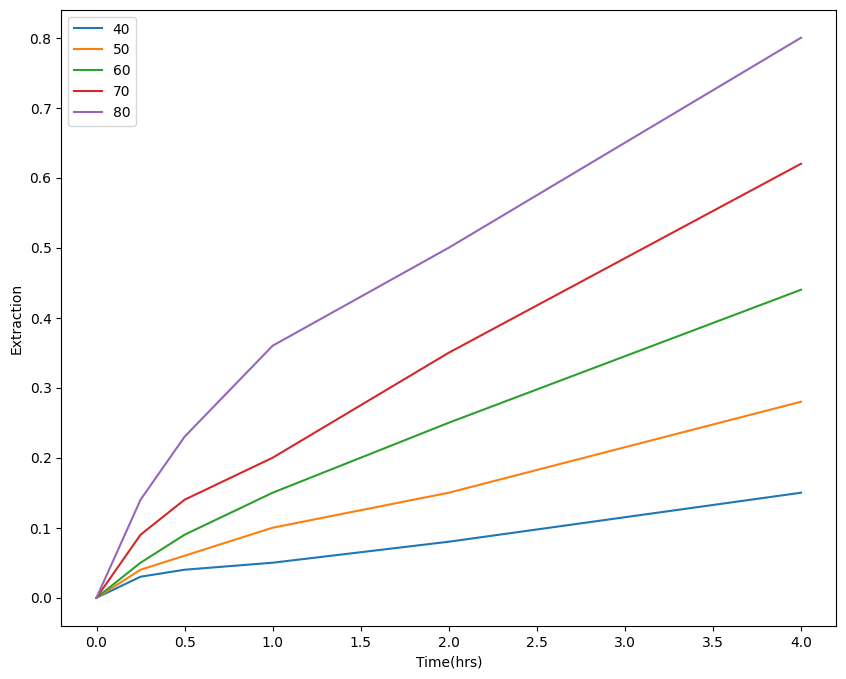

In [14]:
selected_models = [surface_chem,diffusion]
plot_recoveries(df)

40 12.038919044335628 0.9887605338810659
50 24.593035073681733 0.9953755102199806
60 42.75326486462509 0.9984008209590576
70 66.3091158978266 0.9977293954451898
80 98.49304475378848 0.9949638800387076
40 0.6597802761754566 0.9711689846802919
50 2.4922586458499336 0.972563353723707
60 6.864968807598132 0.9757151535707019
70 15.51090962496045 0.96876586983015
80 31.053215945739762 0.9789329906597387


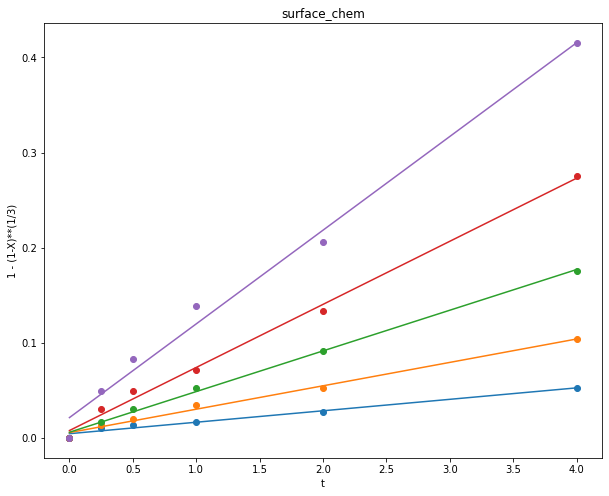

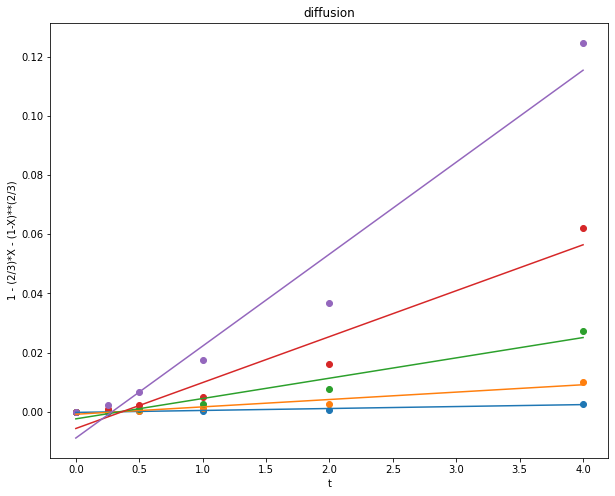

In [44]:
plot_linear_kinetic_selected_models(selected_models)

     Rvalue         Model
1  0.995046  surface_chem
2  0.973429     diffusion

Best Model Name: surface_chem
Model RValue: 0.996
Model Slope: -5.767 

Collision Frequency (A): 1301509803.0 
Activation Energy: 47.94 Kj/mol


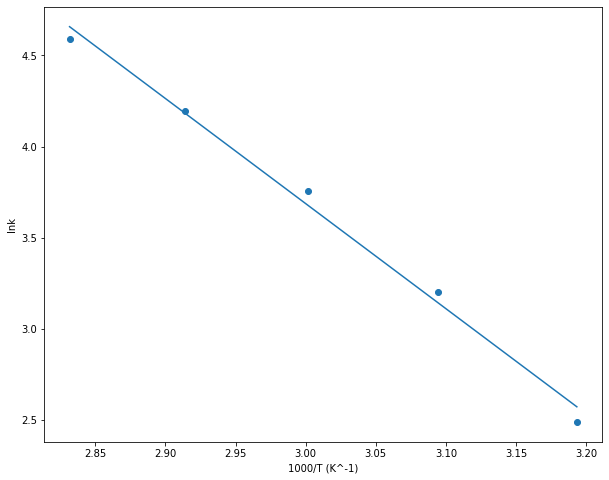

In [38]:
best_model = evaluate_selected_models(selected_models)
TC_kvalue_rvalue_df = evaluate(df,best_model(df)[0])
TC_kvalue_rvalue_df['lnk'] = np.log(TC_kvalue_rvalue_df['k_value'])
TC_kvalue_rvalue_df['1000/T'] = 1000/(TC_kvalue_rvalue_df['Temperature'].astype(int)+273.15)
plt.figure(figsize = (10,8))
plt.scatter(TC_kvalue_rvalue_df['1000/T'],TC_kvalue_rvalue_df['lnk'])
EA_regress = stats.linregress(TC_kvalue_rvalue_df['1000/T'], TC_kvalue_rvalue_df['lnk'])
plt.plot(TC_kvalue_rvalue_df['1000/T'] , (EA_regress.intercept + (EA_regress.slope * TC_kvalue_rvalue_df['1000/T'])))
plt.xlabel('1000/T (K^-1)')
plt.ylabel('lnk')
best_model_rvalue = abs(EA_regress.rvalue)
print()
print("Best Model Name: {}".format(best_model.__name__))
print("Model RValue: {}".format(np.round(best_model_rvalue,3)))
print("Model Slope: {} ".format(np.round(EA_regress.slope,3)))
print()
A = np.exp(EA_regress.intercept)
Ea = -1 * EA_regress.slope * 8.314
print("Collision Frequency (A): {} ".format(np.round(A,0)))
print("Activation Energy: {} Kj/mol".format(np.round(Ea,2))) #KJ/mol because we multplied temperature by 1000

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

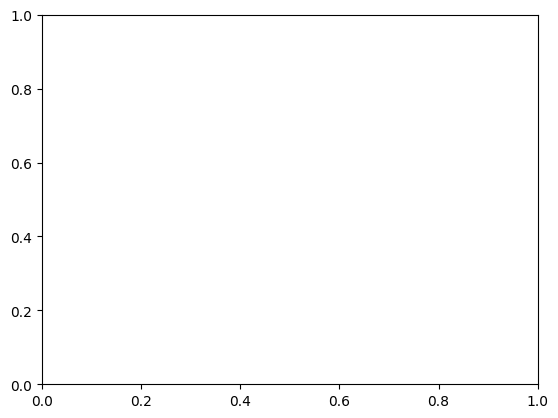

In [12]:
a = [1,2,3]
b = [10,20,30]
for i,entry in enumerate(b):
    plt.plot(a,b[i])